In [835]:
import pandas as pd


In [836]:
# Concatenando os dois datasets em um único e salvando o dataset completo
df_1 = pd.read_csv('winequality-red.csv',sep = ";")
df_2 = pd.read_csv('winequality-white.csv', sep = ";")
df = pd.concat([df_1, df_2], ignore_index=True)
df.to_csv('winequality_full.csv', sep=';', index=False)

In [837]:
# Carregando o novo dataset
df_all = pd.read_csv('winequality_full.csv',sep = ";")
display(df_all)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


**Criando uma nova feature com base na feauture quality para ser uma classificação binaria (0 ou 1)**

In [838]:
# 1 = bom vinho, 0 = vinho ruim
df_all["qualidade_binaria"] = df_all["quality"].apply(lambda x: 0 if x <= 5 else 1)

In [839]:
display(df_all)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,qualidade_binaria
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1


In [840]:
# Separando as features para x_f e a variável alvo para y_v
x_f = df_all.drop(["quality", "qualidade_binaria"], axis=1)
y_v = df_all["qualidade_binaria"]

In [841]:
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import numpy as np
import pytensor.tensor as tt

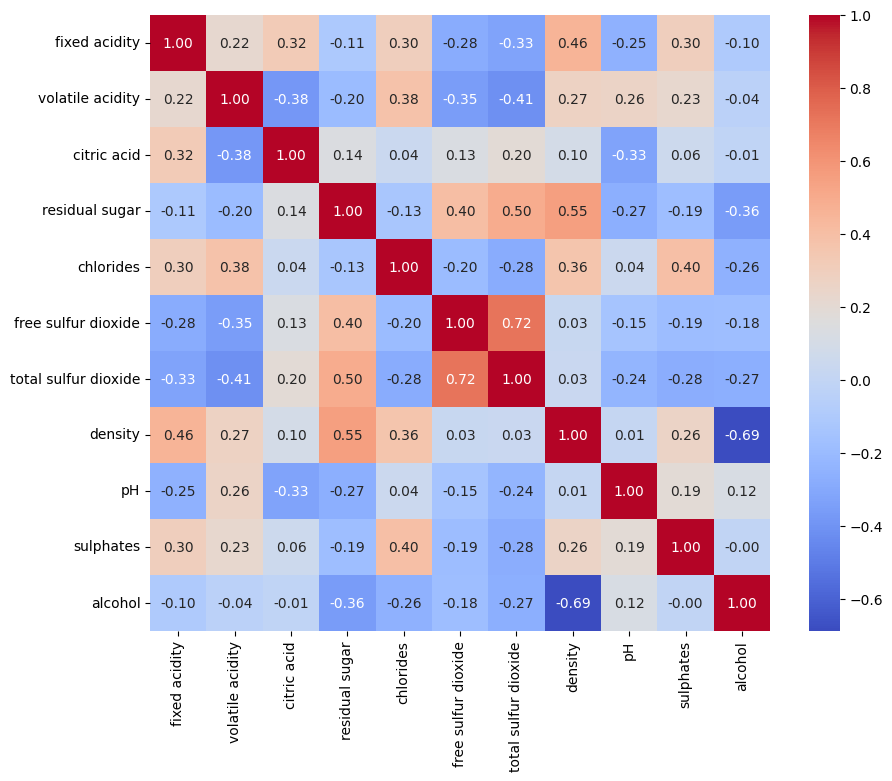

In [842]:
plt.figure(figsize=(10,8))
sns.heatmap(x_f.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()


A feature free sulfur dioxide está altamente correlacionada com a total sulfur dioxide, o que pode ocasionar problemas de multicolinearidade; portanto, vamos verificar essa situação em relação a todas as features escolhidas, pois há outras que também apresentam correlações moderadas a altas entre si.

**Calculando a VIF (Variance Inflation Factor) para verificar a multicolinearidade**

In [843]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

x_f_const = sm.add_constant(x_f)

vif_data = pd.DataFrame({
    'Variável': x_f_const.columns,
    'VIF': [variance_inflation_factor(x_f_const.values, i) for i in range(x_f_const.shape[1])]
})

print(vif_data)


                Variável           VIF
0                  const  1.699783e+06
1          fixed acidity  4.896925e+00
2       volatile acidity  1.949413e+00
3            citric acid  1.608220e+00
4         residual sugar  7.228979e+00
5              chlorides  1.631958e+00
6    free sulfur dioxide  2.135481e+00
7   total sulfur dioxide  2.937601e+00
8                density  1.591450e+01
9                     pH  2.536522e+00
10             sulphates  1.541526e+00
11               alcohol  4.782130e+00


A variável density apresenta um VIF de aproximadamente 15,9, o que indica que
a variável density está altamente correlacionada com outras variáveis preditoras.

**Normalizando todas as variáveis**

In [844]:
x_f["fixed acidity"] = (x_f["fixed acidity"]-x_f["fixed acidity"].mean())/x_f["fixed acidity"].std()
x_f["volatile acidity"] = (x_f["volatile acidity"]-x_f["volatile acidity"].mean())/x_f["volatile acidity"].std()
x_f["citric acid"] = (x_f["citric acid"]-x_f["citric acid"].mean())/x_f["citric acid"].std()
x_f["residual sugar"] = (x_f["residual sugar"]-x_f["residual sugar"].mean())/x_f["residual sugar"].std()
x_f["chlorides"] = (x_f["chlorides"]-x_f["chlorides"].mean())/x_f["chlorides"].std()
x_f["free sulfur dioxide"] = (x_f["free sulfur dioxide"]-x_f["free sulfur dioxide"].mean())/x_f["free sulfur dioxide"].std()
x_f["total sulfur dioxide"] = (x_f["total sulfur dioxide"]-x_f["total sulfur dioxide"].mean())/x_f["total sulfur dioxide"].std()
x_f["density"] = (x_f["density"]-x_f["density"].mean())/x_f["density"].std()
x_f["pH"] = (x_f["pH"]-x_f["pH"].mean())/x_f["pH"].std()
x_f["sulphates"] = (x_f["sulphates"]-x_f["sulphates"].mean())/x_f["sulphates"].std()
x_f["alcohol"] = (x_f["alcohol"]-x_f["alcohol"].mean())/x_f["alcohol"].std()

display(x_f)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.142462,2.188664,-2.192664,-0.744721,0.569914,-1.100055,-1.446247,1.034913,1.812950,0.193082,-0.915394
1,0.451001,3.281982,-2.192664,-0.597594,1.197883,-0.311296,-0.862402,0.701432,-0.115064,0.999502,-0.580023
2,0.451001,2.553104,-1.917405,-0.660648,1.026618,-0.874695,-1.092402,0.768128,0.258100,0.797897,-0.580023
3,3.073580,-0.362411,1.660957,-0.744721,0.541370,-0.762016,-0.986248,1.101609,-0.363840,0.327485,-0.580023
4,0.142462,2.188664,-2.192664,-0.744721,0.569914,-1.100055,-1.446247,1.034913,1.812950,0.193082,-0.915394
...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.783154,-0.787590,-0.197039,-0.807775,-0.486215,-0.367636,-0.420095,-1.186069,0.320294,-0.210128,0.593772
6493,-0.474615,-0.119451,0.284664,0.537383,-0.257863,1.491582,0.924517,0.067819,-0.426034,-0.478935,-0.747709
6494,-0.551750,-0.605370,-0.885185,-0.891847,-0.429127,-0.029596,-0.083942,-0.719196,-1.421138,-0.478935,-0.915394
6495,-1.323097,-0.301671,-0.128224,-0.912866,-0.971463,-0.592996,-0.101635,-2.003097,0.755652,-1.016548,1.935253


Aplicando o PCA nas Variáveis Density, Residual Sugar e Alcohol, free sulfur dioxide , total sulfur dioxide

In [845]:
from sklearn.decomposition import PCA

features_group_1 = ['density', 'residual sugar', 'alcohol']

X_group_1 = x_f[features_group_1]

pca_1 = PCA(n_components=1)
combined_feature_1 = pca_1.fit_transform(X_group_1)
x_f['combinação_componentes_1'] = combined_feature_1

features_group_2 = ['free sulfur dioxide', 'total sulfur dioxide']

X_group_2 = x_f[features_group_2]

pca_2 = PCA(n_components=1)
combined_feature_2 = pca_2.fit_transform(X_group_2)
x_f['combinação_componentes_2'] = combined_feature_2

In [846]:
display(x_f)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,combinação_componentes_1,combinação_componentes_2
0,0.142462,2.188664,-2.192664,-0.744721,0.569914,-1.100055,-1.446247,1.034913,1.812950,0.193082,-0.915394,0.797375,-1.800508
1,0.451001,3.281982,-2.192664,-0.597594,1.197883,-0.311296,-0.862402,0.701432,-0.115064,0.999502,-0.580023,0.469144,-0.829930
2,0.451001,2.553104,-1.917405,-0.660648,1.026618,-0.874695,-1.092402,0.768128,0.258100,0.797897,-0.580023,0.478749,-1.390948
3,3.073580,-0.362411,1.660957,-0.744721,0.541370,-0.762016,-0.986248,1.101609,-0.363840,0.327485,-0.580023,0.646327,-1.236209
4,0.142462,2.188664,-2.192664,-0.744721,0.569914,-1.100055,-1.446247,1.034913,1.812950,0.193082,-0.915394,0.797375,-1.800508
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.783154,-0.787590,-0.197039,-0.807775,-0.486215,-0.367636,-0.420095,-1.186069,0.320294,-0.210128,0.593772,-1.510504,-0.557010
6493,-0.474615,-0.119451,0.284664,0.537383,-0.257863,1.491582,0.924517,0.067819,-0.426034,-0.478935,-0.747709,0.751675,1.708440
6494,-0.551750,-0.605370,-0.885185,-0.891847,-0.429127,-0.029596,-0.083942,-0.719196,-1.421138,-0.478935,-0.915394,-0.388841,-0.080284
6495,-1.323097,-0.301671,-0.128224,-0.912866,-0.971463,-0.592996,-0.101635,-2.003097,0.755652,-1.016548,1.935253,-2.854961,-0.491178


In [847]:
# Dropando as antigas features, já que temos agora elas combinadas em uma só
x_f = x_f.drop(['density', 'residual sugar', 'alcohol','free sulfur dioxide', 'total sulfur dioxide'], axis=1)

In [848]:
display(x_f)

,fixed acidity,volatile acidity,citric acid,chlorides,pH,sulphates,combinação_componentes_1,combinação_componentes_2
0,0.142462,2.188664,-2.192664,0.569914,1.812950,0.193082,0.797375,-1.800508
1,0.451001,3.281982,-2.192664,1.197883,-0.115064,0.999502,0.469144,-0.829930
2,0.451001,2.553104,-1.917405,1.026618,0.258100,0.797897,0.478749,-1.390948
3,3.073580,-0.362411,1.660957,0.541370,-0.363840,0.327485,0.646327,-1.236209
4,0.142462,2.188664,-2.192664,0.569914,1.812950,0.193082,0.797375,-1.800508
...,...,...,...,...,...,...,...,...
6492,-0.783154,-0.787590,-0.197039,-0.486215,0.320294,-0.210128,-1.510504,-0.557010
6493,-0.474615,-0.119451,0.284664,-0.257863,-0.426034,-0.478935,0.751675,1.708440
6494,-0.551750,-0.605370,-0.885185,-0.429127,-1.421138,-0.478935,-0.388841,-0.080284
6495,-1.323097,-0.301671,-0.128224,-0.971463,0.755652,-1.016548,-2.854961,-0.491178


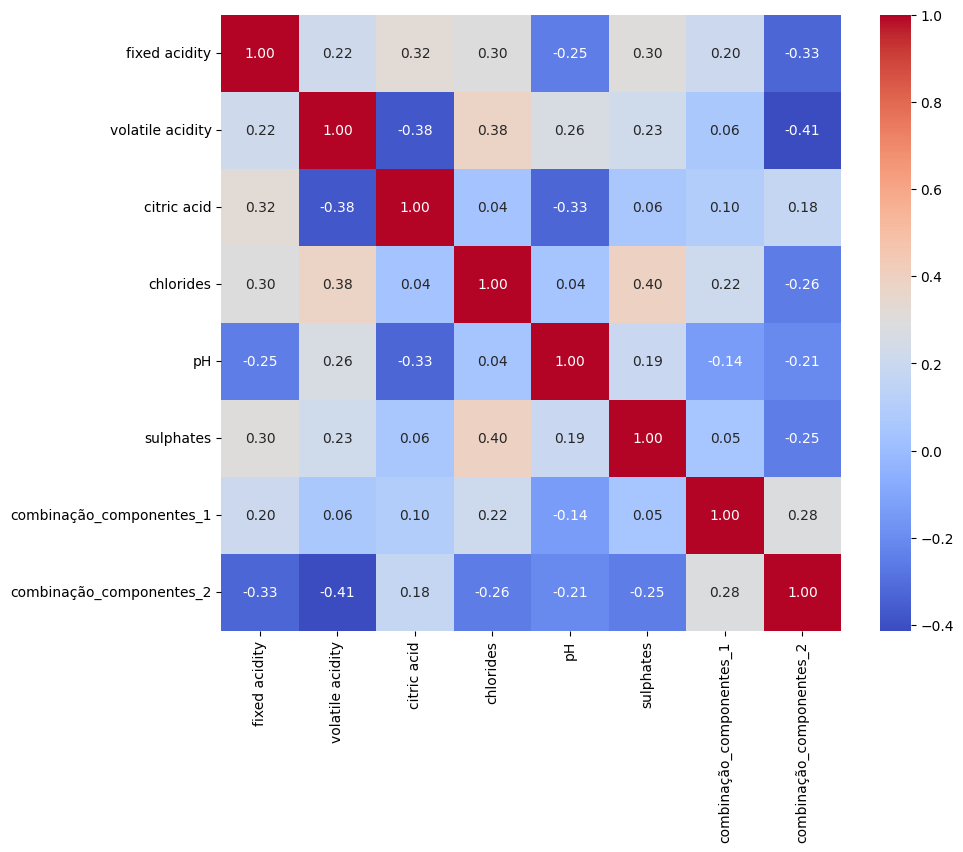

In [849]:
plt.figure(figsize=(10,8))
sns.heatmap(x_f.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

**Verificando mais uma vez o VIF (Variance Inflation Factor)**

In [850]:
x_f_const = sm.add_constant(x_f)

vif_data = pd.DataFrame({
    'Variável': x_f_const.columns,
    'VIF': [variance_inflation_factor(x_f_const.values, i) for i in range(x_f_const.shape[1])]
})

print(vif_data)

                   Variável       VIF
0                     const  1.000000
1             fixed acidity  1.818449
2          volatile acidity  1.710551
3               citric acid  1.558038
4                 chlorides  1.450360
5                        pH  1.360386
6                 sulphates  1.339371
7  combinação_componentes_1  1.323738
8  combinação_componentes_2  1.712879


Tudo certo, podemos continuar

In [851]:
from sklearn.model_selection import train_test_split

x_treino, x_teste, y_treino, y_teste = train_test_split(x_f, y_v, test_size=0.3, random_state=42)

In [852]:
display(x_treino)

,fixed acidity,volatile acidity,citric acid,chlorides,pH,sulphates,combinação_componentes_1,combinação_componentes_2
3761,2.070829,0.913127,-0.609926,0.883898,-2.789406,-0.613338,0.218560,-0.468465
3740,0.373866,-0.362411,0.215849,-0.000967,0.320294,-0.210128,2.579236,0.034616
1359,3.382119,0.822017,0.559923,0.998074,-0.923586,0.797897,0.276640,-2.074761
1230,0.373866,-0.969809,0.147035,0.284474,0.942234,1.671518,-0.929491,-1.340906
4751,0.296732,-0.544630,6.271540,-0.600391,-1.172362,-0.680540,-2.305037,3.045711
...,...,...,...,...,...,...,...,...
3772,0.296732,-0.119451,1.798587,-0.172231,-0.426034,0.058679,2.951193,1.088151
5191,-1.245962,-0.362411,-0.334668,-0.372039,0.817846,-0.613338,-0.833228,1.384145
5226,-0.628884,0.184248,-0.816370,1.740219,0.133712,-0.680540,0.473718,2.055448
5390,-0.551750,-0.483890,1.248069,-0.143687,-0.239452,-0.411733,0.897073,1.633018


In [853]:
display(y_treino)

,qualidade_binaria
3761,1
3740,0
1359,1
1230,1
4751,1
...,...
3772,0
5191,1
5226,0
5390,0


In [854]:
coords = {
    'features': ['fixed acidity',	'volatile acidity', 'citric acid' ,	'chlorides','pH','sulphates',	'combinação_componentes_1','combinação_componentes_2']
}

In [855]:
with pm.Model(coords=coords) as model:
  betas = pm.Normal("beta",0,10,dims="features")
  alpha = pm.Normal("alpha",0,10)

  X = [
    pm.MutableData("X_"+column,x_treino[column].values)
    for column in x_treino.columns if np.issubdtype(x_f[column].dtype, np.number)
  ]

  y = pm.MutableData("y",y_treino)

  mu = alpha + tt.dot(betas,X)
  likelihood = pm.Bernoulli("likelihood",pm.math.invlogit(mu),observed=y)

/usr/local/lib/python3.11/dist-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


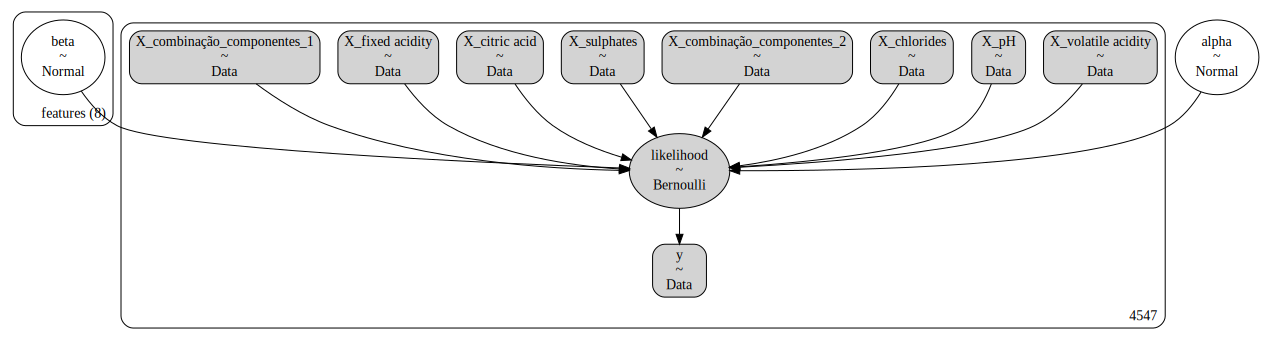

In [856]:
pm.model_to_graphviz(model)

In [857]:
with model:
  trace = pm.sample()

Output()

In [858]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.604,0.032,0.545,0.663,0.001,0.001,3456.0,1438.0,1.0
beta[fixed acidity],0.107,0.046,0.015,0.188,0.001,0.001,2147.0,1446.0,1.0
beta[volatile acidity],-0.708,0.048,-0.797,-0.619,0.001,0.001,2538.0,1553.0,1.0
beta[citric acid],-0.036,0.040,-0.113,0.035,0.001,0.001,2671.0,1668.0,1.0
beta[chlorides],-0.189,0.042,-0.266,-0.109,0.001,0.001,3175.0,1705.0,1.0
beta[pH],0.083,0.041,0.011,0.162,0.001,0.001,2850.0,1780.0,1.0
beta[sulphates],0.331,0.044,0.248,0.412,0.001,0.001,2722.0,1602.0,1.0
beta[combinação_componentes_1],-0.424,0.028,-0.479,-0.373,0.001,0.001,2909.0,1813.0,1.0
beta[combinação_componentes_2],-0.020,0.034,-0.089,0.038,0.001,0.001,2381.0,1752.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

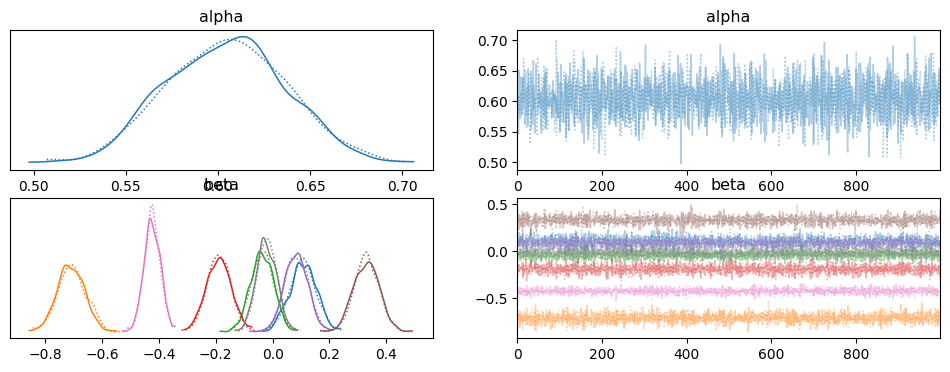

In [859]:
az.plot_trace(trace)

In [860]:
vars = {"X_"+column : x_teste[column].values
    for column in x_teste.columns if np.issubdtype(x_teste[column].dtype, np.number)}
vars["y"] = y_teste

In [861]:
with model:
  pm.set_data(vars)
  trace_post = pm.sample_posterior_predictive(trace)

Output()

In [862]:
mean_likelihood = trace_post.posterior_predictive['likelihood'].mean(dim=['chain', 'draw'])
predicao = (mean_likelihood > 0.5).astype(int)

In [863]:
abs_diff = np.abs(y_teste - predicao)

df = pd.DataFrame({
    'y_teste': y_teste,
    'Predição_modelo': predicao,
    'absoluta_diferença': abs_diff
})

df

,y_teste,Predição_modelo,absoluta_diferença
3103,1,1,0
1419,0,0,0
4761,1,1,0
4690,1,1,0
4032,1,0,1
...,...,...,...
4294,1,1,0
3757,1,1,0
5954,1,1,0
4418,1,1,0


In [864]:
errors = df["absoluta_diferença"].sum()
acc = (len(df)-errors)/len(df)
print(f"acurácia: {acc*100:.2f}%")
print(f"Erros: {errors}")

acurácia: 71.03%
Erros: 565


Uma Acurácia de 71.03% é ok

In [865]:
class1 = df["y_teste"].sum()
class0 = len(df)-class1

print(f"Classe vinho ruim: {class0}")
print(f"Classe vinho bom: {class1}")

Classe vinho ruim: 691
Classe vinho bom: 1259


In [866]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_teste, predicao)

recall = recall_score(y_teste, predicao)

f1 = f1_score(y_teste, predicao)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.7496
Recall: 0.8276
F1 Score: 0.7867


Precisão: 74.96%​
Isso sugere que o modelo tem uma taxa moderada de falsos positivos.

Recall: 82,76%​
indicando uma boa capacidade de detectar casos positivos e uma taxa relativamente baixa de falsos negativos.

F1 Score: 78,67%
Esse valor sugere um desempenho sólido do modelo.

# **Consideração Final**
O modelo apresentou um desempenho razoável, porém acredito que esse seja o seu limite. Testei com diferentes priors, variando a média e a variância:
0,1| 0,2| 0,3| 0,4| 0,5| 0,10| 0,15|  0, 0.5| 0,0.25| 0,0.75| 0,100 e apenas com algumas features como 'alcohol' ,	'density' ,	'residual sugar' ,	'volatile acidity' e depois usei o PCA para evitar a multicolinearidade nas features 'alcohol' ,	'density' ,	'residual sugar' "juntando" elas em apenas um componente, ficando 'volatile acidity' e componente, mesmo assim a acurácia do modelo não passava de 69%, essa configuração usando todas variáveis e fazendo dois componentes separados para as variáveis com moderada/alta correlação foi o que obteve a melhor acurácia,  talvez testar outro modelo para classificação melhore mais a acurácia.